# Indian Liver Patient Records

Use supervised learning on the Indian patient records to determine which patients have liver disease. The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)


1. [Results](#nn_result): confusion matrix, most correct and most incorrect predictions for each class
     
2. [Conclusions](#con): 

In [1]:
#import packages
import sys
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')
#sys.path.append(r'C:\Users\Benny\Anaconda3\envs\fastai\Lib\site-packages\graphviz')

%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.column_data import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, roc_auc_score)
from sklearn.model_selection import train_test_split

from IPython.display import display
import seaborn as sns
plt.style.use('ggplot')

import feather

The data exploration were done previous [the random forest notebook](#https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb)

In [2]:
df_raw=pd.read_feather('tmp/liver_patient_raw')

In [3]:
df_raw.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,ill
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,ill
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,ill
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,ill
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,ill


In [4]:
df, y, nas, mapper = proc_df(df_raw,y_fld='Dataset', do_scale=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                              583 non-null float64
Gender                           583 non-null int8
Total_Bilirubin                  583 non-null float64
Direct_Bilirubin                 583 non-null float64
Alkaline_Phosphotase             583 non-null float64
Alamine_Aminotransferase         583 non-null float64
Aspartate_Aminotransferase       583 non-null float64
Total_Protiens                   583 non-null float64
Albumin                          583 non-null float64
Albumin_and_Globulin_Ratio       583 non-null float64
Albumin_and_Globulin_Ratio_na    583 non-null float64
dtypes: float64(10), int8(1)
memory usage: 46.2 KB


In [6]:
df.drop('Albumin_and_Globulin_Ratio_na', axis=1, inplace=True)

In [7]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

x_trn = df[~mask]
x_val = df[mask]
y_trn = y[~mask]
y_val = y[mask]

In [8]:
_, nunique_trn = np.unique(y_trn, return_counts=True)
_, nunique_val = np.unique(y_val, return_counts=True)

print(f'Training data has {nunique_trn[1]/nunique_trn.sum()} ill patients')
print(f'Validataion data has {nunique_val[1]/nunique_val.sum()} ill patients')

Training data has 0.7100456621004566 ill patients
Validataion data has 0.7241379310344828 ill patients


## Neural Network Classifier

Using FastAi library, we first build a model data from a thedataframe. Using idxs variable to split the data into train and val set. Calcualte the size of the embedding metrix. Then build a model object with get_learner.  

In [9]:
# construct a model data
md = ColumnarModelData.from_data_frame('', val_idxs=idxs, df=df, y=y.astype(np.int64), cat_flds=['Gender'], is_reg=False,
                                      bs=512)

In [10]:
# calculate the size of the embedding matrix for the categorical variables
cat_vars = ['Gender']
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]; cat_sz
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(3, 2)]

In [11]:
# build a nn model object
mnn = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, out_sz=2, szs=[200, 20], drops=[0.001, 0.01], y_range=None)
mnn.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', tensor(6))])),
             ('Dropout-2',
              OrderedDict([('input_shape', [-1, 2]),
                           ('output_shape', [-1, 2]),
                           ('nb_params', 0)])),
             ('BatchNorm1d-3',
              OrderedDict([('input_shape', [-1, 9]),
                           ('output_shape', [-1, 9]),
                           ('trainable', True),
                           ('nb_params', tensor(18))])),
             ('Linear-4',
              OrderedDict([('input_shape', [-1, 11]),
                           ('output_shape', [-1, 200]),
                           ('trainable', True),
                           ('nb_params', tensor(2400))])),
             ('Dropout-5',
              OrderedDict([('input_shape', [-1, 200]),
             

In [12]:
# pick a learning rate 
lr = 1e-4

In [13]:
# start fitting
mnn.fit(lr, 20, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                           
    0      0.910521   0.879284   0.289655  
    1      0.905258   0.873359   0.289655                                           
    2      0.904407   0.867512   0.296552                                           
    3      0.897898   0.861762   0.303448                                           
    4      0.894458   0.856116   0.317241                                           
    5      0.89068    0.850603   0.317241                                           
    6      0.887143   0.845175   0.310345                                           
    7      0.883125   0.83983    0.296552                                           
    8      0.880215   0.834579   0.303448                                           
    9      0.876636   0.829393   0.296552                                           
    10     0.872997   0.824288   0.296552                                           
    11     0.869632  

[0.781731367111206, 0.317241370677948]

In [15]:
mnn.fit(lr, 20, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                           
    0      0.683505   0.702725   0.586207  
    1      0.682746   0.699528   0.6                                                
    2      0.681062   0.696383   0.6                                                
    3      0.679431   0.693311   0.613793                                           
    4      0.677603   0.6903     0.613793                                           
    5      0.676347   0.687332   0.627586                                           
    6      0.674807   0.684418   0.627586                                           
    7      0.673582   0.681564   0.627586                                           
    8      0.671565   0.678788   0.627586                                           
    9      0.670327   0.676061   0.648276                                           
    10     0.66833    0.673397   0.668966                                           
    11     0.666805  

[0.6517074704170227, 0.7103448510169983]

In [27]:
mnn.fit(lr, 10, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                           
    0      0.540256   0.531113   0.724138  
    1      0.538573   0.530315   0.724138                                           
    2      0.53872    0.529494   0.724138                                           
    3      0.538526   0.528719   0.724138                                           
    4      0.53782    0.527941   0.724138                                           
    5      0.537509   0.527207   0.724138                                           
    6      0.537187   0.52648    0.724138                                           
    7      0.537176   0.525772   0.724138                                           
    8      0.536706   0.525072   0.724138                                           
    9      0.536263   0.52439    0.724138                                           



[0.5243901014328003, 0.7241379022598267]

In [28]:
mnn.save('indian_mnn')

## Analyse NN results <a id='nn_result'></a>

In [29]:
#https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
def nn_feat_importance(m, md, cat_vars, cont_vars):
    """ Computes the feature importance for each categorical and continuous column
    m is a fastai.column_data.StructuredLearner
    md is a fastai.column_data.ColumnarModelData
    cat_vars is a list with the categorical vars names as used to define m and md
    cont_vars is a list with the continuous vars names as used to define m and md
    """
    loss0 = np.array([to_np(m.crit(m.model(x_cat, x_cont), y)) for x_cat, x_cont, y in iter(md.val_dl)]).mean()
    fi = dict()
    for i, c in enumerate(cat_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cat[:, i] = x_cat[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    for i, c in enumerate(cont_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cont[:, i] = x_cont[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})


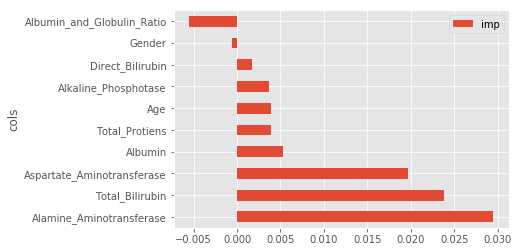

In [30]:
con_vars = df.columns.drop(cat_vars)
finn = nn_feat_importance(mnn, md, cat_vars, con_vars)
finn.plot('cols','imp','barh')

In [31]:
finn

,cols,imp
0,Alamine_Aminotransferase,0.029498
1,Total_Bilirubin,0.023854
2,Aspartate_Aminotransferase,0.019631
3,Albumin,0.005311
4,Total_Protiens,0.003857
5,Age,0.003853
6,Alkaline_Phosphotase,0.003704
7,Direct_Bilirubin,0.001736
8,Gender,-0.000560
9,Albumin_and_Globulin_Ratio,-0.005539


In [32]:
log_preds = mnn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1537: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.72      1.00      0.84       105

   micro avg       0.72      1.00      0.84       105
   macro avg       0.72      1.00      0.84       105
weighted avg       0.72      1.00      0.84       105



([<matplotlib.axis.YTick at 0x21e8f5a5518>,
 <a list of 2 Text yticklabel objects>)

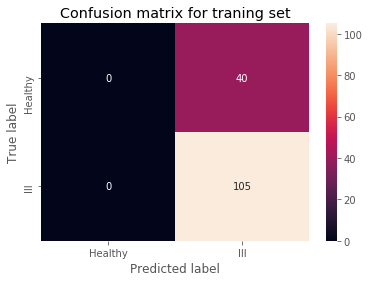

In [34]:
print('Classification Report validation set: \n', classification_report(y_val,preds, 
                                                        target_names=['Healthy', 'Ill'], labels=np.unique(preds)))

sns.heatmap(confusion_matrix(y_val,preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for traning set')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In [33]:
roc_auc_score(y_val, preds)

0.5

## Conclusions <a id='con'></a>

Using two hidden layers neutral network predict 72% accuracy and high false positive rate, which is worse than logsitic regression. This maybe due to the small amount of data.

